In [1]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torchaudio.transforms as T
import torchvision
import torch.optim as optim
import scipy as sp
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import datetime

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [99]:
root_dir = os.path.join('/data', 'EPIC-KITCHENS')
annotations_dir = os.path.join('..', 'data', 'annotations')
train = True
filename = 'EPIC_100_train_clean.pkl'

img_dir = os.path.join('..','reports','img','dataset_analysis')

In [3]:
def load_data(filename):
    '''
    Load the WAV file and its label.
    Args :
        • filename: str. The path of a WAV file.
    Returns A tuple of two Pandas DataFrame objects:
        • signals: A DataFrame with the following columns:
            • seconds: The time in seconds.
            • AcclX: The acceleration along the x-axis.
            • AcclY: The acceleration along the y-axis.
            • AcclZ: The acceleration along the z-axis.
            • GyroX: The angular velocity along the x-axis.
            • GyroY: The angular velocity along the y-axis.
            • GyroZ: The angular velocity along the z-axis.
        • sampling_rate: The sampling rate of the WAV file.
    '''
    # TODO: Load the WAV file and its label
    df_accl = pd.read_csv(filename + '-accl.csv').dropna().reset_index(drop=True)
    df_gyro = pd.read_csv(filename + '-gyro.csv').dropna().reset_index(drop=True)

    return df_accl, df_gyro

In [4]:
df = pd.read_pickle(os.path.join(annotations_dir, filename))
df = df.dropna()
df = df.reset_index(drop=True)
df

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01,P01_102,00:00:01.100,00:00:00.54,00:00:02.23,27,111,take knife and plate,take,0,knife,4,"[knife, plate]","[4, 2]"
1,P01,P01_102,00:00:07.600,00:00:07.49,00:00:09.05,374,452,move spatula and colander,move,11,spatula,20,"[spatula, colander]","[20, 39]"
2,P01,P01_102,00:00:29.851,00:00:29.66,00:00:30.84,1483,1542,take knife,take,0,knife,4,[knife],[4]
3,P01,P01_102,00:03:44.600,00:03:44.45,00:03:45.00,11222,11250,wipe surface,wipe,2,surface,42,[surface],[42]
4,P01,P01_102,00:03:45.600,00:03:45.61,00:03:46.01,11280,11300,move glass,move,11,glass,10,[glass],[10]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37450,P37,P37_103,00:06:16.903,00:06:17.17,00:06:17.67,18858,18883,turn off tap,turn-off,8,tap,0,[tap],[0]
37451,P37,P37_103,00:06:22.154,00:06:17.86,00:06:23.77,18893,19188,take pan,take,0,pan,5,[pan],[5]
37452,P37,P37_103,00:06:26.404,00:06:23.45,00:06:32.66,19172,19633,pour out boiled water,pour-out,9,water:boiled,27,[water:boiled],[27]
37453,P37,P37_103,00:00:41.151,00:00:40.57,00:00:44.19,2028,2209,debone chicken thighs,debone,30,thigh:chicken,57,[thigh:chicken],[57]


In [ ]:
accl_data = pd.DataFrame(columns=['video_id', 'Milliseconds', 'AcclX', 'AcclY', 'AcclZ'])
gyro_data = pd.DataFrame(columns=['video_id', 'Milliseconds', 'GyroX', 'GyroY', 'GyroZ'])

# 1. Actions Duration

In [5]:
unique_verbs = df['verb'].unique()
unique_verbs

array(['take', 'move', 'wipe', 'throw-into', 'put-down', 'wash', 'pour',
       'turn-off', 'rinse', 'dry', 'put-onto', 'close', 'open',
       'put-into', 'turn-on', 'move-into', 'adjust', 'empty', 'pick-up',
       'put', 'attach-onto', 'pour-into', 'fold', 'shake', 'twist-off',
       'unfold', 'squeeze', 'hand', 'dice', 'stir', 'peel', 'take-from',
       'grind', 'slice', 'take-off', 'tap', 'cut', 'flatten', 'open-with',
       'throw', 'compress', 'separate', 'wipe-off', 'pull-down',
       'take-out', 'remove', 'lift', 'lay', 'pat-down', 'set', 'lather',
       'grab', 'drain', 'scoop', 'spoon', 'immerge', 'spray', 'throw-off',
       'pick', 'check', 'lower', 'move-onto', 'scrape', 'crush',
       'take-up', 'remove-from', 'sprinkle', 'gather', 'wipe-with',
       'press', 'rotate', 'drink', 'crack', 'split', 'eat', 'get',
       'pour-onto', 'press-down', 'distribute', 'move-around', 'flip',
       'hang', 'wrap', 'wrap-around', 'wrap-with', 'fix', 'switch-on',
       'put-in'

## Discrepanza col dataset
Dovrebbero esserci:
* verbs: 97
* nouns: 300

In [6]:
len(df['verb_class'].unique()), len(df['verb'].unique())

(89, 622)

In [7]:
len(df['noun_class'].unique()), len(df['noun'].unique())

(251, 1267)

In [10]:
tmp_df = df
tmp_df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format='%H:%M:%S.%f')
tmp_df['stop_timestamp'] = pd.to_datetime(df['stop_timestamp'], format='%H:%M:%S.%f')

diff_df = pd.DataFrame({
    'diff': df['stop_timestamp'] - df['start_timestamp'],
    'verb': df['verb'],
    'verb_class': df['verb_class'],
    'noun': df['noun'],
    'noun_class': df['noun_class'],
})

In [11]:
diff_df

,diff,verb,verb_class,noun,noun_class
0,0 days 00:00:01.690000,take,0,knife,4
1,0 days 00:00:01.560000,move,11,spatula,20
2,0 days 00:00:01.180000,take,0,knife,4
3,0 days 00:00:00.550000,wipe,2,surface,42
4,0 days 00:00:00.400000,move,11,glass,10
...,...,...,...,...,...
37450,0 days 00:00:00.500000,turn-off,8,tap,0
37451,0 days 00:00:05.910000,take,0,pan,5
37452,0 days 00:00:09.210000,pour-out,9,water:boiled,27
37453,0 days 00:00:03.620000,debone,30,thigh:chicken,57


In [14]:
diff_df['diff'].describe()

count                        37455
mean     0 days 00:00:02.627286076
std      0 days 00:00:05.191817418
min         0 days 00:00:00.200000
25%         0 days 00:00:00.850000
50%         0 days 00:00:01.340000
75%         0 days 00:00:02.540000
max         0 days 00:04:57.150000
Name: diff, dtype: object

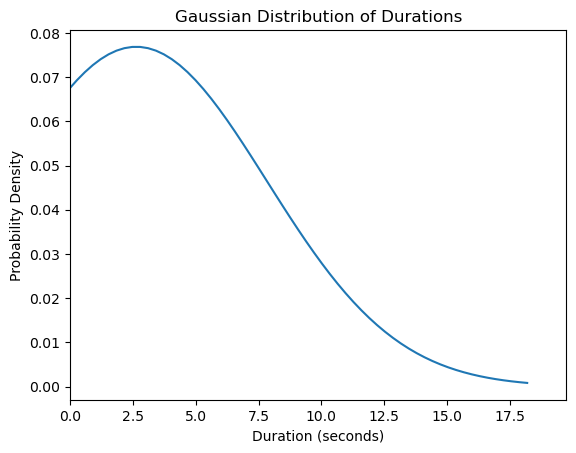

<Figure size 640x480 with 0 Axes>

In [102]:
from scipy.stats import norm
import matplotlib.pyplot as plt

# Calculate mean and standard deviation
mean = diff_df['diff'].mean().total_seconds()
std = diff_df['diff'].std().total_seconds()

# Generate x values for the Gaussian curve
x = np.linspace(mean - 3*std, mean + 3*std, 100)

# Calculate y values using the Gaussian distribution
y = norm.pdf(x, mean, std)

# Plot the Gaussian curve
plt.plot(x, y)
plt.xlabel('Duration (seconds)')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution of Durations')
plt.xlim(left=0)
plt.show()
plt.savefig(os.path.join(img_dir, 'duration_distribution_pdf.svg'))


In [22]:
diff_df['diff'].dt.total_seconds().describe()

count    37455.000000
mean         2.627286
std          5.191817
min          0.200000
25%          0.850000
50%          1.340000
75%          2.540000
max        297.150000
Name: diff, dtype: float64

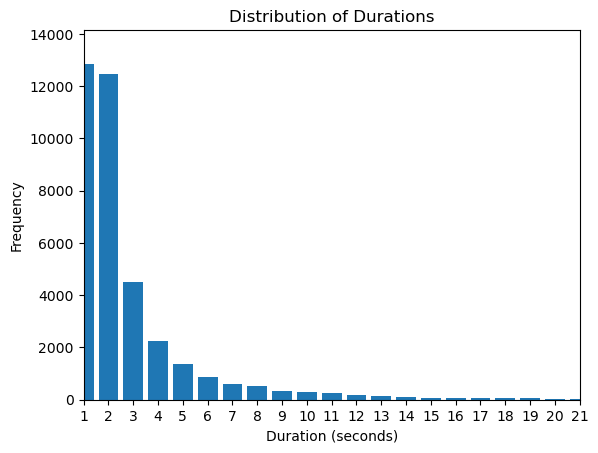

<Figure size 640x480 with 0 Axes>

In [101]:
import matplotlib.pyplot as plt

stats = np.ceil(diff_df['diff'].dt.total_seconds().to_numpy()).astype(int)
limit = 20

labels, counts = np.unique(stats, return_counts=True)
x = np.arange(labels.max())
# Plot the distribution of 'diff' column
plt.bar(labels.astype(str), counts, data=counts, align='center')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Durations')
plt.margins(x=0.01, y=0.1)
plt.xlim(0, 20)
plt.show()
plt.savefig(os.path.join(img_dir, 'duration_distribution_bar.svg'))